In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import glob
import os
import sklearn.model_selection


## Metadata Loading and Preprocessing

We load the metadata CSV, select relevant columns, encode categorical features (like `sex` and `diagnosis_1`), and handle missing values. Additionally, we create a new `filename` column to link metadata with corresponding image files.

In [2]:

metadata = pd.read_csv('metadata.csv')
metadata = metadata[['isic_id','age_approx','clin_size_long_diam_mm','sex','diagnosis_1']]
# encode columns
metadata['sex'] = metadata['sex'].map({'male': 0, 'female': 1})
metadata['diagnosis_1'] = metadata['diagnosis_1'].map({'Benign': 0, 'Malignant': 1})

# missing values
metadata['age_approx'] = metadata['age_approx'].fillna(metadata['age_approx'].mean())
metadata['clin_size_long_diam_mm'] = metadata['clin_size_long_diam_mm'].fillna(metadata['clin_size_long_diam_mm'].mean())
metadata = metadata.dropna()

# Create filename field
metadata['filename'] = metadata['isic_id'].astype(str) + '.jpg'


/var/folders/0b/33n254b510726mq07nrfcfbw0000gn/T/ipykernel_16678/695260491.py:1: DtypeWarning: Columns (6,9,10,11,13,14,15,16,17,18,19,22,23,25,26,27,28,30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('metadata.csv')


In [3]:
benign_df = metadata[metadata['diagnosis_1'] == 0]
malignant_df = metadata[metadata['diagnosis_1'] == 1]

benign_downsampled = benign_df.sample(
    n=len(malignant_df),
    random_state=42,
    replace=False
)

metadata = pd.concat([malignant_df, benign_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
metadata.head()

,isic_id,age_approx,clin_size_long_diam_mm,sex,diagnosis_1,filename
0,ISIC_5096775,45.0,3.000000,1.0,0.0,ISIC_5096775.jpg
1,ISIC_0066001,60.0,3.988203,0.0,1.0,ISIC_0066001.jpg
2,ISIC_2766590,80.0,3.988203,0.0,1.0,ISIC_2766590.jpg
3,ISIC_5166694,65.0,3.010000,0.0,0.0,ISIC_5166694.jpg
4,ISIC_0067079,55.0,3.988203,1.0,1.0,ISIC_0067079.jpg


## Linking Metadata with Valid Image Files

We read a list of verified image paths and filter the metadata to only include entries with matching image files. This ensures all image paths used in training have corresponding metadata.

In [5]:
'''
good_image_paths = []

for path in valid_image_paths:
    try:
        img_raw = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        good_image_paths.append(path)
    except:
        print(f"Skipping invalid image: {path}")

with open('good_image_paths.txt', 'w') as f:
    for path in good_image_paths:
        f.write(f"{path}\n")
'''

'\ngood_image_paths = []\n\nfor path in valid_image_paths:\n    try:\n        img_raw = tf.io.read_file(path)\n        img = tf.image.decode_jpeg(img_raw, channels=3)\n        good_image_paths.append(path)\n    except:\n        print(f"Skipping invalid image: {path}")\n\nwith open(\'good_image_paths.txt\', \'w\') as f:\n    for path in good_image_paths:\n        f.write(f"{path}\n")\n'

In [6]:
with open('good_image_paths.txt', 'r') as f:
    image_paths = [line.strip() for line in f]

filenames = [os.path.basename(p) for p in image_paths]
metadata = metadata[metadata['filename'].isin(filenames)].reset_index(drop=True)


## Creating Lookup Dictionaries

We generate lookup dictionaries to map filenames to their corresponding labels and metadata values (like sex, age, and lesion size). These will be used to efficiently build the dataset.

In [7]:
# Create lookup dictionaries
label_lookup = dict(zip(metadata['filename'], metadata['diagnosis_1']))
sex_lookup = dict(zip(metadata['filename'], metadata['sex']))
age_lookup = dict(zip(metadata['filename'], metadata['age_approx']))
size_lookup = dict(zip(metadata['filename'], metadata['clin_size_long_diam_mm']))

# Lists for matched data
valid_image_paths = []
labels = []
sex_features = []
age_features = []
size_features = []

for path, fname in zip(image_paths, filenames):
    if fname in label_lookup:
        valid_image_paths.append(path)
        labels.append(label_lookup[fname])
        sex_features.append(sex_lookup[fname])
        age_features.append(age_lookup[fname])
        size_features.append(size_lookup[fname])



## Train-Test Split

We split the dataset into training/validation and test sets using a 90/10 ratio. This prepares the data for model training and final evaluation.

In [8]:
trainval_paths, test_paths, trainval_labels, test_labels, \
trainval_sex, test_sex, trainval_age, test_age, trainval_size, test_size = sklearn.model_selection.train_test_split(
    valid_image_paths, labels, sex_features, age_features, size_features,
    test_size=0.1, random_state=42, shuffle=True
)


In [9]:
len(trainval_paths)

32815

## Preparing Test Dataset

We copy the test set images into a dedicated directory to match the structure required by TensorFlow’s image dataset loader.

In [10]:

import os
import shutil

os.makedirs('./images_trainval2', exist_ok=True)

for path in trainval_paths:
    filename = os.path.basename(path)
    shutil.copy(path, f'./images_trainval2/{filename}')

os.makedirs('./images_test2', exist_ok=True)

for path in test_paths:
    filename = os.path.basename(path)
    shutil.copy(path, f'./images_test2/{filename}')

## Creating TensorFlow Image Datasets

We use `image_dataset_from_directory` to create batched, shuffled image datasets for training, validation, and testing. Labels are provided as one-hot encoded vectors for multi-class classification.

In [11]:
trainval_path_to_label = {os.path.basename(p): l for p, l in zip(trainval_paths, trainval_labels)}
trainval_filenames = [os.path.basename(p) for p in trainval_paths]
trainval_labels_sorted = [trainval_path_to_label[fname] for fname in trainval_filenames]


train_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./images_trainval2',
    labels=trainval_labels_sorted,
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=123,
    validation_split=0.2, 
    subset="training"
)

val_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./images_trainval2',
    labels=trainval_labels_sorted,
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation"
)


Found 32815 files belonging to 2 classes.
Using 26252 files for training.
Found 32815 files belonging to 2 classes.
Using 6563 files for validation.


In [12]:
# Test filenames and labels
test_path_to_label = {os.path.basename(p): l for p, l in zip(test_paths, test_labels)}
test_filenames = [os.path.basename(p) for p in test_paths]
test_labels_sorted = [test_path_to_label[fname] for fname in test_filenames]

test_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./images_test2',
    labels=test_labels_sorted,
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=False
)


Found 3647 files belonging to 2 classes.


In [13]:
train_metadata_ds = tf.data.Dataset.from_tensor_slices(
    tf.stack([trainval_sex[:len(train_image_ds)], trainval_age[:len(train_image_ds)], trainval_size[:len(train_image_ds)]], axis=1)
)

val_metadata_ds = tf.data.Dataset.from_tensor_slices(
    tf.stack([trainval_sex[len(train_image_ds):], trainval_age[len(train_image_ds):], trainval_size[len(train_image_ds):]], axis=1)
)

test_metadata_ds = tf.data.Dataset.from_tensor_slices(
    tf.stack([test_sex, test_age, test_size], axis=1)
)


## Merging Image Data with Metadata

We create TensorFlow datasets from metadata features and zip them with image datasets. This allows us to use both image and non-image features during model training. However, this notebook only uses image data for training.

In [14]:
train_images_only_ds = train_image_ds.map(lambda x, y: x)
train_labels_only_ds = train_image_ds.map(lambda x, y: y)

train_inputs_ds = tf.data.Dataset.zip((train_images_only_ds, train_metadata_ds))
final_train_ds = tf.data.Dataset.zip((train_inputs_ds, train_labels_only_ds)).prefetch(tf.data.AUTOTUNE)

val_images_only_ds = val_image_ds.map(lambda x, y: x)
val_labels_only_ds = val_image_ds.map(lambda x, y: y)

val_inputs_ds = tf.data.Dataset.zip((val_images_only_ds, val_metadata_ds))
final_val_ds = tf.data.Dataset.zip((val_inputs_ds, val_labels_only_ds)).prefetch(tf.data.AUTOTUNE)

test_images_only_ds = test_image_ds.map(lambda x, y: x)
test_labels_only_ds = test_image_ds.map(lambda x, y: y)

test_inputs_ds = tf.data.Dataset.zip((test_images_only_ds, test_metadata_ds))
final_test_ds = tf.data.Dataset.zip((test_inputs_ds, test_labels_only_ds)).prefetch(tf.data.AUTOTUNE)




## Building a Simple CNN Using Keras Sequential API

This code defines a function `build_simple_cnn_sequential` that creates a Convolutional Neural Network (CNN) using TensorFlow's Keras `Sequential` API. The network is designed for binary classification on image data with shape `(128, 128, 3)` since we resized the images to 128x128.

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

def build_simple_cnn_sequential(input_shape=(128, 128, 3)):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model


## Defining Callbacks for Training

We define two callbacks to monitor and control training:

- **EarlyStopping**: Stops training early if the validation loss does not improve after a specified number of epochs.
- **ModelCheckpoint**: Saves the best model (based on validation loss) during training.

In [16]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # watch validation loss
    patience=3,            # stop if no improvement for 3 epochs
    restore_best_weights=True
)


In [17]:
checkpoint_simple = keras.callbacks.ModelCheckpoint(
    filepath='best_simple_cnn.h5',
    monitor='val_loss',
    save_best_only=True
)

## Compiling and Training the CNN Model

Now we build, compile, and train the CNN model defined earlier using the training and validation datasets. We use:

- **Adam** optimizer
- **Binary cross-entropy** loss function (suitable for binary classification)
- **Accuracy** as the evaluation metric

We also use the previously defined callbacks (`early_stopping` and `checkpoint_simple`) to manage training.

In [18]:
model_simple = build_simple_cnn_sequential()

# Compile
model_simple.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
history_simple = model_simple.fit(
    train_image_ds,
    validation_data=val_image_ds,
    epochs=5,
    callbacks=[early_stopping, checkpoint_simple]
)

# Save final model
model_simple.save('final_simple_cnn_model.h5')

Epoch 1/5
820/821 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4956 - loss: 37.4272

821/821 ━━━━━━━━━━━━━━━━━━━━ 95s 115ms/step - accuracy: 0.4956 - loss: 37.3529 - val_accuracy: 0.4938 - val_loss: 0.6932
Epoch 2/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 93s 113ms/step - accuracy: 0.4942 - loss: 0.6937 - val_accuracy: 0.4992 - val_loss: 0.6933
Epoch 3/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 93s 114ms/step - accuracy: 0.4955 - loss: 0.6945 - val_accuracy: 0.4944 - val_loss: 0.6941
Epoch 4/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 94s 114ms/step - accuracy: 0.4971 - loss: 0.6950 - val_accuracy: 0.4950 - val_loss: 0.6985


## Evaluating the Trained Model on the Test Set

We define a function `evaluate_model_on_test()` that performs a thorough evaluation of the trained model on the test dataset. The function:

- Generates predictions and applies a classification threshold.
- Displays a confusion matrix.
- Calculates key metrics: **Precision**, **Recall**, **F1 Score**, and **AUC**.
- Plots the **ROC Curve**.

This allows us to better understand model performance beyond simple accuracy.

114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step


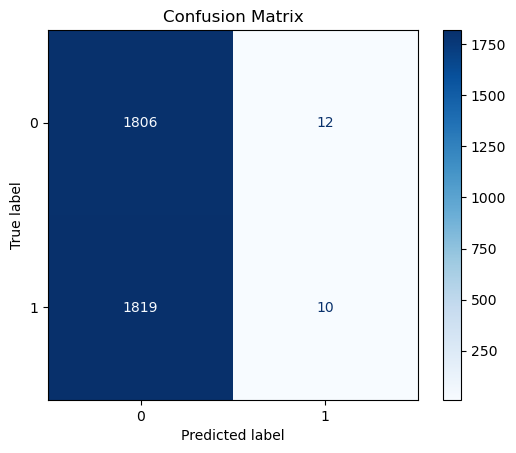

Precision: 0.4545
Recall: 0.0055
F1 Score: 0.0108


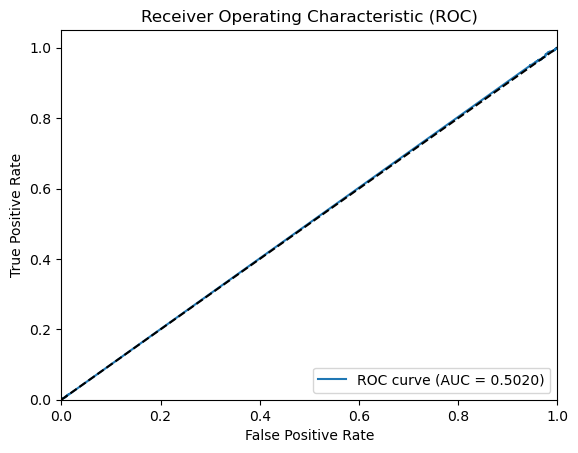

AUC: 0.5020


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_curve, auc

def evaluate_model_on_test(model, test_ds, threshold=0.5):
    # Predict
    y_pred_probs = model.predict(test_ds)
    y_pred = (y_pred_probs > threshold).astype(int)
    
    # Get true labels
    y_true = []
    for (img, meta), label in test_ds.take(114):
        y_true.append(label.numpy())
    y_true = np.concatenate(y_true, axis=0)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Precision, Recall, F1
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # random classifier line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"AUC: {roc_auc:.4f}")


evaluate_model_on_test(model_simple, final_test_ds)


In [ ]:
# very little predictive power, almost always predicts 0